<a href="https://colab.research.google.com/github/bperz/complex_systems/blob/master/list4/list4-task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab setup

In [0]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My\ Drive
!if [ ! -d complex_systems_lab_4 ]; then mkdir complex_systems_lab_4; fi
%cd complex_systems_lab_4

In [0]:
!echo "deb http://downloads.skewed.de/apt/bionic bionic universe" >> /etc/apt/sources.list
!apt-key adv --keyserver hkp://keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool

# Building blocks

## Iporting libraries

In [0]:
from graph_tool.all import *
import numpy as np
# omit if numba in verion >= 46.0
!pip install numba --upgrade
from numba import njit, prange
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pickle

## Watts-Strogatz graph functions

In [0]:
@njit()
def small_world(old_edges, new_edges, nodes, beta=0.01):
  """ Shuffle circular_graph edges """


  for i, vertex in enumerate(old_edges[:,1]):
    if np.random.rand() < beta:
      new_edges[i] = np.random.choice(nodes)
    else:
      new_edges[i] = vertex
  

In [0]:
def generate_WS(N, k, beta):
  """
  Generate Watts-Strogatz Graph.
  Takes number of edges, number of neighbours and probability of rewiring as an input.
  Creates undirected circular graph with parameters N, k and shuffles its edges.
  """
  
  G_ws = graph_tool.generation.circular_graph(N, k, directed=False)
  edges = G_ws.get_edges()
  nodes = G_ws.get_vertices()

  new_edges = np.zeros((len(edges),), dtype=np.int32)

  small_world(edges, new_edges, nodes, beta)
  edges[:, 1] = new_edges
  G_ws.clear_edges()
  G_ws.add_edge_list(edges)

  return G_ws

## Additional functions

In [0]:
def generate_graph(graph_type, k, N, beta=0.01, verbose=False):
  """
  Generate graph of given type. Possible types: 
    'WS' -> 'Watts-Strogatz graph', 
    'G'-> 'Random graph' 
    'BA' -> 'Barabasi-Albert graph'

  Outputs graph
  """

  if verbose == True:
    clear_output(wait=True)
    display('Generating graph {0} k:{1} N:{2}'.format(graph_type, k, N))

  if graph_type == 'WS':
    G = generate_WS(N, k, beta)
  if graph_type == 'G':
    G = graph_tool.generation.random_graph(N, lambda: np.random.poisson((N-1)*k/N), directed=False, model="erdos")
  if graph_type == 'BA':
    G = graph_tool.generation.price_network(N, k//2, directed=False)

  return G


def vertices_high_to_low(G, attack_mode):
  """ Sort vertices according to attack mode, from highest to lowest"""

  if attack_mode == 'closeness':
    prop = graph_tool.centrality.closeness(G).get_array()
  elif attack_mode == 'betweenness':
    prop = graph_tool.centrality.betweenness(G)[0].get_array()
  else:
    prop = G.degree_property_map('total').get_array()
    
  return np.flip(np.argsort(prop))


def examine_graph(G, k, N, fraction_list, realization = 1, start=None, high_to_low=False, attack_mode='', verbose=False):
  """
  Examine graph. Check how fraction of deleted nodes affects largest component's size.
  Delete nodes according to strategy specified in high_to_low. 
  If high_to_low == True, remove nodes according to their degree, from highest to lowest, and check largest component size.
  If high_to_low == False, remove nodes randomly.
  Save components' sizes to Pfs.
  """
 
  if verbose == True:
      clear_output(wait=True)
      display('k: ' + str(k) + ', '+
              'N: ' + str(N) + ', '+
              'realization: ' + str(realization)
              )
      display("Stage 1")
      display(time.time()-start)

  # save size of largest component before analysis  
  P0 = graph_tool.topology.extract_largest_component(G, prune=True).get_vertices().shape[0]

  Pfs = np.zeros(len(fraction_list))

  # if high_to_low == False perform random deletion, else delete according to attack_mode
  if high_to_low == True:
    rm_nodes_holder = vertices_high_to_low(G, attack_mode)
  else:
    rm_nodes_holder = G.get_vertices()
    np.random.shuffle(rm_nodes_holder)

  if verbose == True:
      display("Stage 2")
      display(time.time()-start)

  # for fraction in fraction list delete fraction of nodes nodes
  for i, f in enumerate(fraction_list):
    if f == 0.0:
      Pfs[i] = P0
      continue

    # copy not to affect original graph
    temp_G = G.copy()

    # take f fraction of nodes for deletion
    rm_nodes = np.copy(rm_nodes_holder[:int(f*rm_nodes_holder.shape[0])])
    rm_nodes.sort()


    # remove nodes from temporary graph
    temp_G.remove_vertex(rm_nodes, fast=True)
    Pfs[i] = graph_tool.topology.extract_largest_component(temp_G, prune=True).get_vertices().shape[0]

  return Pfs/P0


def generate_and_examine(fraction_list, sizes, k_list, graph_type, beta = 0.01, no_realizations = 1, verbose = False, load_from_file = False, high_to_low = False, attack_mode=''):
  """ Perform generation and examination of graph according to specified parameters. """
  results = {}

  start = time.time()
  for k in k_list:
    for N in sizes:
      result_holder = np.zeros((no_realizations, len(fraction_list)))

      for realization in range(no_realizations):
        if verbose == True:
          clear_output(wait=True)
          if load_from_file == True:
            display('loading graph k: {}, N: {}'.format(k,N))
          else:
            display('generating graph k: {}, N: {}'.format(k,N))

        if load_from_file == True:
          G = load_graph(graph_type, k, N)
        else:
          G = generate_graph(graph_type, k, N, beta, verbose = verbose)     

        result_holder[realization] = examine_graph(G, k, N, fraction_list, realization, start=start, high_to_low = high_to_low, attack_mode = attack_mode, verbose = verbose)

      results.setdefault((k,N), np.mean(result_holder, axis=0))

  return results
  

def create_plots(fraction_list, sizes, k_list, results, name, task, xscale='linear', yscale='linear'):
  """ Plot size of giant component vs deleted fraction"""
  full_names = {'WS':'Watts-Strogatz graph', 'G':'Random graph', 'BA': 'Barabasi-Albert graph'}
  x = fraction_list

  plt.figure(figsize=(10,6))
  ys = []
  for i,k in enumerate(k_list):
    for key in [(k,size) for size in sizes]:
      ys.append(results[key])

  for j, (y, c) in enumerate(zip(ys, ['bo-', 'gx-', 'r*-'])):
    plt.plot(x, y, c, label='k: ' + str(k_list[j]))
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(task + ', ' + full_names[name] + ', size = ' + str(sizes[0])[0] + 'e' + str(int(np.log10(sizes[0]))))
    plt.xlabel('fraction of deleted nodes')
    plt.ylabel('relative size of the giant component')
    plt.legend()
    plt.savefig('{}_{}.svg'.format(task, name), format='svg')
    

# Task 1

## Watts-Strogatz graph

'k: 12, N: 10000, realization: 9'

'Stage 1'

477.44752955436707

'Stage 2'

502.7477023601532

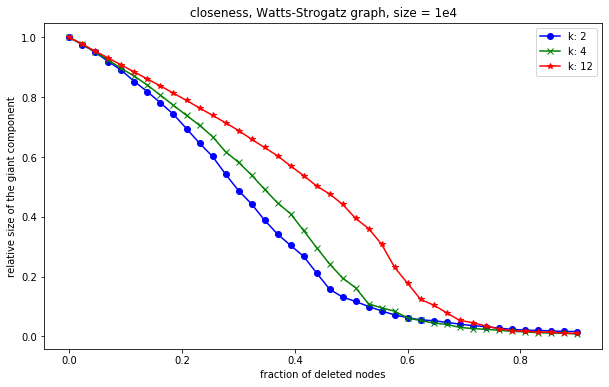

In [0]:
fraction_list = np.linspace(0, 0.9, 40)
sizes = np.array([1e4],dtype=np.int32)
k_list = [2, 4, 12]

results = generate_and_examine(fraction_list, sizes, k_list, 'WS', beta=0.01, no_realizations=10, high_to_low = True, attack_mode = 'closeness', verbose = True)

create_plots(fraction_list, sizes, k_list, results, 'WS', task='closeness')


## Random graph

'k: 12, N: 10000, realization: 9'

'Stage 1'

387.26379227638245

'Stage 2'

407.0204575061798

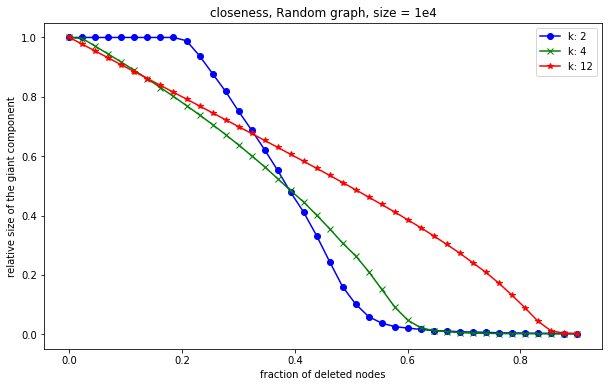

In [0]:
fraction_list = np.linspace(0, 0.9, 40)
sizes = np.array([1e4],dtype=np.int32)
k_list = [2, 4, 12]


results = generate_and_examine(fraction_list, sizes, k_list, 'G', no_realizations=10, high_to_low = True, attack_mode = 'closeness', verbose=True)
create_plots(fraction_list, sizes, k_list, results, 'G', task='closeness')

## Barabasi-Albert graph

'k: 12, N: 10000, realization: 9'

'Stage 1'

409.36583280563354

'Stage 2'

430.01489186286926

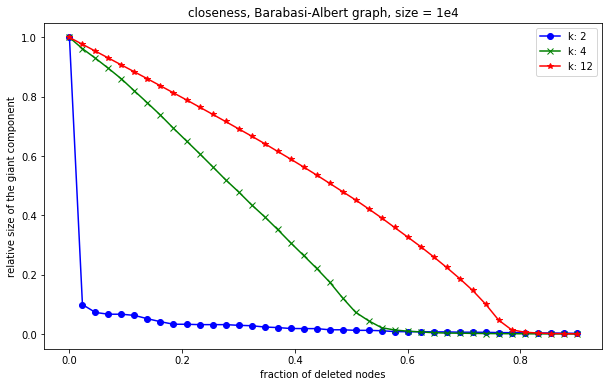

In [0]:
fraction_list = np.linspace(0, 0.9, 40)
sizes = np.array([1e4],dtype=np.int32)
k_list = [2, 4, 12]

results = generate_and_examine(fraction_list, sizes, k_list, 'BA', no_realizations=10, high_to_low = True, attack_mode = 'closeness', verbose=True)
create_plots(fraction_list, sizes, k_list, results, 'BA', task='closeness')

# Task 2

## Watts-Strogatz graph

'k: 12, N: 10000, realization: 9'

'Stage 1'

640.1623663902283

'Stage 2'

676.5752251148224

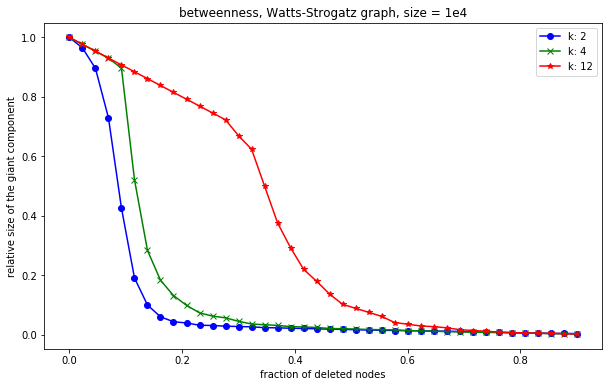

In [0]:
fraction_list = np.linspace(0, 0.9, 40)
sizes = np.array([1e4],dtype=np.int32)
k_list = [2, 4, 12]

results = generate_and_examine(fraction_list, sizes, k_list, 'WS', beta=0.01, no_realizations=10, high_to_low = True, attack_mode = 'betweenness', verbose = True)

create_plots(fraction_list, sizes, k_list, results, 'WS', task='betweenness')


## Random graph

'k: 12, N: 10000, realization: 9'

'Stage 1'

564.0633263587952

'Stage 2'

599.0704853534698

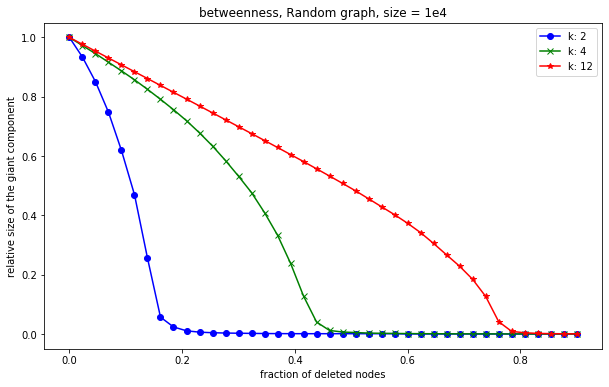

In [0]:
fraction_list = np.linspace(0, 0.9, 40)
sizes = np.array([1e4],dtype=np.int32)
k_list = [2, 4, 12]

results = generate_and_examine(fraction_list, sizes, k_list, 'G', no_realizations=10, high_to_low = True, attack_mode = 'betweenness', verbose = True)

create_plots(fraction_list, sizes, k_list, results, 'G', task='betweenness')

## Barabasi-Albert graph

'k: 12, N: 10000, realization: 9'

'Stage 1'

531.3459210395813

'Stage 2'

563.9705610275269

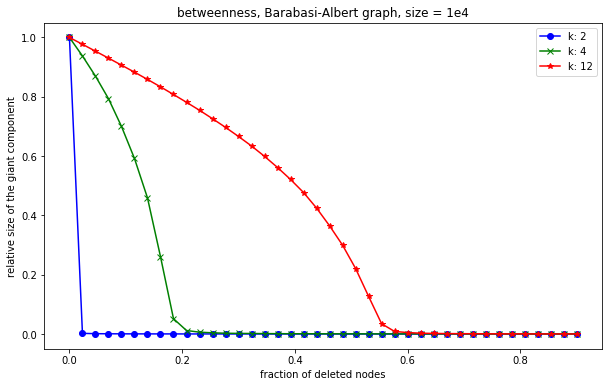

In [0]:
fraction_list = np.linspace(0, 0.9, 40)
sizes = np.array([1e4],dtype=np.int32)
k_list = [2, 4, 12]

results = generate_and_examine(fraction_list, sizes, k_list, 'BA', no_realizations=10, high_to_low = True, attack_mode = 'betweenness', verbose = True)

create_plots(fraction_list, sizes, k_list, results, 'BA', task='betweenness')
